# CS 7180 Geometric Deep Learning, Homework 1: CNNs and GNNs

## TLDR

* **To start solving the homework, create a copy of this notebook:** `File -> Save a copy in Drive`.
* **To hand-in the homework**, email your PDF with answers to `biza.o@northeastern.edu` and add `biza.o@northeastern.edu` as a `Commentor` using the `Share` button **in your copy of this notebook**.
* Deadline is Wednesday February 1st, 5 PM EST.

## Solving the homework in Google Colab

[Google Colab](colab.research.google) is an online platform for running interactive Python session with [Jupyter](https://jupyter.org/) / [IPython](https://ipython.org/) (`.ipynb`) notebooks. We recommend you use it so that we can avoid problems with setting up local Python environment and so that we can use free GPUs to accelerate neural network training. 

If you have not used Python notebooks before, please check [this overview](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). If you are new to Python, you can refer to [this excellent Python Numpy Tutorial](https://cs231n.github.io/python-numpy-tutorial/). We will be using [Numpy](https://numpy.org/) and [PyTorch](https://pytorch.org/) extensively to prepare data and train neural networks. For a PyTorch tutorial, follow [this link](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) and select `Run in Google Colab`.

You cannot save the changes you made to this notebook. To start solving the homework, create a copy that you can edit: `File -> Save a copy in Drive`.

By default, your instance will run on a CPU. That is ok, but training neural network might take a while. You can (and should) request a free GPU instance using: `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU` (-> `Delete previous runtime` -> `OK`). Note that your GPU instance will stop due to inactivity or a 12-hour time limit, but you can usually immediately request a new one. This will however delete all your progress (e.g. network weights) that is not saved in your code blocks, text blocks or Google Drive.

Another useful command to reset your instance (keeps your GPU):
`Runtime` -> `Restart runtime`.

## Handing in the homework

Please email a PDF with your answers to `biza.o@northeastern.edu`. We recommend you write-up your answers in latex (e.g. [overleaf.com](https://www.overleaf.com)). Please also share your copy of this notebook by clicking `Share` in the top-right corner, adding `biza.o@northeastern.edu`, setting me as `Commentor` and enabling `Notify people`. Another option is to email your `.ipynb` to me.

## Deadline
The deadline for this homework is **Wednesday February 1st, 5 PM EST**. You should email your solution to me by that time.

## (Optional) Solving the homework on your local machine
You can download this notebook using `Download -> Download .ipynb` and run it on your local machine. To set up a local environment, download [Python 3.6](https://www.python.org/) or later, set up a [virtual environment](https://docs.python.org/3/library/venv.html) and install [relevant packages](https://pip.pypa.io/en/stable/reference/requirements-file-format/) using [pip](https://pypi.org/project/pip/). On Linux, you would do something like this:

```
# Assuming you have Python >= 3.6 and python3-venv installed.
python3 -m venv venv
source ./venv/bin/activate
# Prevents opencv-python (which we might use) from taking forever to install.
pip install --upgrade pip setuptools wheel
pip install -r requirements.txt
pip install jupyter
# Run in the directory where this notebook is located. A browser window should open.
jupyter notebook .
```

You can run `!pip freeze` *in colab* to see the version of packages we are using. Then, you can copy the relevant packages (i.e. the ones we import) to your `requirements.txt` file or install them using `pip install x` in command line or `!pip install x` directly in the notebook. Importantly, to run on your GPU, you will need to install a `torch` version that matches your [CUDA](https://developer.nvidia.com/cuda-downloads) and [cuDNN](https://developer.nvidia.com/cudnn) versions. Please refer to the [PyTorch website](https://pytorch.org/). We might use the CPU version of tensorflow to prepare datasets.

# Python setup

In [ ]:
import os
# I like to use typing, but you don't have to!
from typing import Any, Dict, Tuple, Union

import networkx as nx
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import scipy.sparse as sp
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms

# We might use tensorflow to load datasets.
# Prevent tensorflow from stealing our GPU.
tf.config.experimental.set_visible_devices([], "GPU")

# Interactive plots.
%matplotlib inline

In [ ]:
# Runtime -> Change runtime type -> Hardware accelerator -> GPU (-> Delete previous runtime -> OK).
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
  print("PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.")
  device = torch.device("cuda:0")
else:
  print("WARNING: PyTorch running on a CPU. See comment above to request a GPU instance.")
  device = torch.device("cpu")

PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.


# Part 1: Training a convolutional network on MNIST, measuring translation equivariance.

In this part, we will experiment with [MNIST](http://yann.lecun.com/exdb/mnist/), the quintessential deep learning dataset. You will implement and train a convolutional neural network, and measure its equivariance and invariance to translations. In 1999, [Yan LeCunn wrote](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf) "A large degree of invariance to geometric transformations of the input can be achieved with this [referring to subsampling and pooling in a CNN] progressive reduction of spatial resolution compensated by progressive increase of the richness of the representation (the number of feature maps)." Let's see if that's true!

## Data preprocessing

In [ ]:
def prepare_mnist(batch_size: int) -> Tuple[DataLoader, DataLoader]:
  """Prepare MNIST training and evaluation data loaders in PyTorch.
  # https://github.com/pytorch/examples/blob/main/mnist/main.py
  """
  t = transforms.ToTensor()

  train_ds = datasets.MNIST("/tmp/mnist", download=True, train=True, transform=t)
  eval_ds = datasets.MNIST("/tmp/mnist", download=True, train=False, transform=t)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=1)

  return train_loader, eval_loader

In [ ]:
def translate(image: Union[torch.Tensor, NDArray], delta_x: float, delta_y: float) -> Union[torch.Tensor, NDArray]:
  """Translate an image. Either torch.Tensor or numpy.ndarray. Can be HxWxC or CxHxW."""
  is_torch = False
  if type(image) == torch.Tensor:
    # Pytorch to numpy.
    is_torch = True
    tmp = image.to("cpu").detach().numpy()
  else:
    tmp = image

  if len(tmp.shape) == 2:
    # HxW
    delta = [delta_x, delta_y]
  else:
    assert len(tmp.shape) == 3, "Invalid number of dimensions in an image, should be 2 or 3."
    if tmp.shape[0] in [1, 3]:
      # CxHxW
      delta = [0, delta_x, delta_y]
    elif tmp.shape[2] in [1, 3]:
      # HxWxC
      delta = [delta_x, delta_y, 0]
    else:
      raise ValueError("Invalid number of channels in an image, should be 1 or 3.")

  # Shift and automatically add zero padding.
  tmp = shift(image, delta)

  if is_torch:
    tmp = torch.tensor(tmp, dtype=image.dtype, device=image.device)
  return tmp

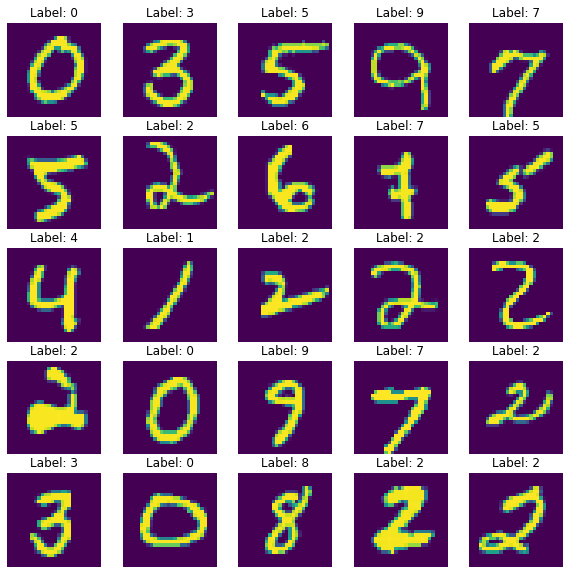

In [ ]:
train_loader, eval_loader = prepare_mnist(128)
example = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5*5):
  plt.subplot(5, 5, 1 + i)
  plt.title("Label: {:d}".format(example[1][i]))
  plt.imshow(example[0][i][0])
  plt.axis("off")

Translate by [-5, -2, 0, 2, 5].


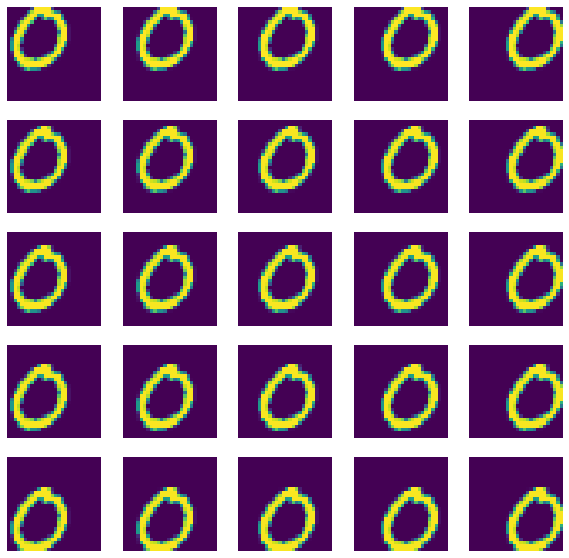

In [ ]:
img = example[0][0]
transl = [-5, -2, 0, 2, 5]
print("Translate by {}.".format(transl))
plt.figure(figsize=(10, 10))
for i in range(5):
  for j in range(5):
    tmp = translate(img, transl[i], transl[j])
    plt.subplot(5, 5, 1 + j + i * 5)
    plt.imshow(tmp[0])
    plt.axis("off")

## Training a baseline

In [ ]:
class MLPBaseline(nn.Module):
  """A Multi Layer Perceptron baseline.
  It flattens the input image and applies three fully-connected layers
  each followed by an activation."""
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28 * 28, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
    self.act = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    x = x.reshape(x.shape[0], -1)

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    # Our loss function expect log probabilities of the 10 digit classes.
    x = F.log_softmax(self.fc3(x), dim=-1)

    return x

In [ ]:
def train(train_loader: DataLoader, model: nn.Module,
          optimizer: optim.Optimizer, epochs: int):

  losses = []
  # 1 epoch = 1 pass through the dataset.
  for epoch in range(epochs):
    print("Epoch {:d} / {:d}".format(epoch, epochs))
    # train_loader steps once it iterates over all data.
    for train_step, batch in enumerate(train_loader):
      # train_loader gives us batched images (CxHxW) and labels (integers).
      # If we are using a GPU we need to move them to the device.
      inputs, labels = batch[0].to(device), batch[1].to(device)
      # Reset last optimization step.
      optimizer.zero_grad()
      # Make prediction, calculate loss.
      outputs = model(inputs)
      loss = F.nll_loss(outputs, labels)
      # Compute gradients and update weights.
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if train_step > 0 and train_step % 50 == 0:
        print("Mean of last 50 losses: {:f}".format(np.mean(losses[-50:])))

  plt.plot(losses)
  plt.xlabel("Training step")
  plt.ylabel("Loss")

In [ ]:
# We don't need gradients during evaluation.
@torch.no_grad()
def evaluate(eval_loader: DataLoader, model: nn.Module):

  accuracy = []

  for batch in eval_loader:
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    pred_labels = torch.argmax(outputs, dim=-1)
    tmp = (labels == pred_labels).float().mean()
    accuracy.append(tmp.item())

  # We compute the mean of means over batches.
  # This could be slightly skewed if the last batch is smaller.
  # Does not matter too much here.
  accuracy = np.mean(accuracy)
  print("Correct answer in {:.1f}% of cases.".format(accuracy * 100))

In [ ]:
@torch.no_grad()
def plot_predictions(eval_loader: DataLoader, model: nn.Module):
  example = next(iter(eval_loader))
  inputs = example[0].to(device)
  outputs = model(inputs)
  pred_labels = torch.argmax(outputs, dim=-1).to("cpu").numpy()

  plt.figure(figsize=(10, 10))
  for i in range(5*5):
    plt.subplot(5, 5, 1 + i)
    plt.title("Label: {:d}".format(pred_labels[i]))
    plt.imshow(example[0][i][0])
    plt.axis("off")

Epoch 0 / 5
Mean of last 50 losses: 1.208871
Mean of last 50 losses: 0.410971
Mean of last 50 losses: 0.339762
Mean of last 50 losses: 0.306199
Mean of last 50 losses: 0.303037
Mean of last 50 losses: 0.269672
Mean of last 50 losses: 0.260488
Mean of last 50 losses: 0.232948
Mean of last 50 losses: 0.215763
Epoch 1 / 5
Mean of last 50 losses: 0.161685
Mean of last 50 losses: 0.181896
Mean of last 50 losses: 0.196959
Mean of last 50 losses: 0.170022
Mean of last 50 losses: 0.150322
Mean of last 50 losses: 0.160618
Mean of last 50 losses: 0.145069
Mean of last 50 losses: 0.132207
Mean of last 50 losses: 0.139334
Epoch 2 / 5
Mean of last 50 losses: 0.105617
Mean of last 50 losses: 0.118967
Mean of last 50 losses: 0.124947
Mean of last 50 losses: 0.114590
Mean of last 50 losses: 0.102834
Mean of last 50 losses: 0.108330
Mean of last 50 losses: 0.093085
Mean of last 50 losses: 0.109723
Mean of last 50 losses: 0.099885
Epoch 3 / 5
Mean of last 50 losses: 0.083839
Mean of last 50 losses: 0.09

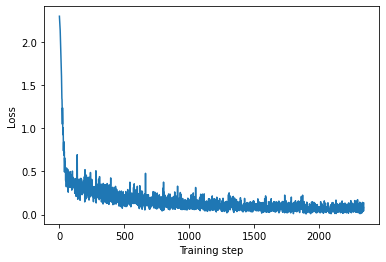

In [ ]:
model = MLPBaseline().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(train_loader, model, optimizer, 5)

In [ ]:
evaluate(eval_loader, model)

Correct answer in 97.4% of cases.


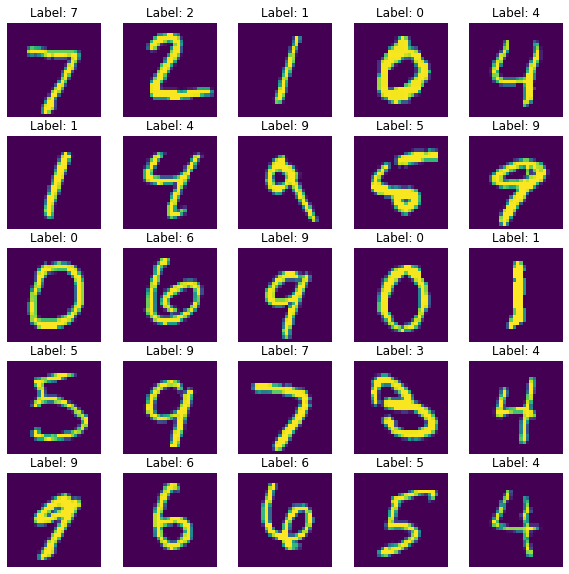

In [ ]:
plot_predictions(eval_loader, model)

## == Task 1 ==

[**Question 1**] Implement a convolutional neural network and report its learning curve (loss vs training steps) and validation accuracy compared to the MLP baseline we implemented. An *example* of a model you could use is: `CNN(64 kernels, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) -> ReLU -> CNN(64 kernels, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) -> ReLU -> CNN(64 kernels, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) -> ReLU -> Flatten to vector -> Linear(128) -> ReLU -> Linear(10) -> LogSoftmax.`

[**Question 2**] Plot validation accuracy vs training dataset size for the CNN and the MLP. The full MNIST training set size is 60k. You can choose any interesting range of dataset sizes. Make sure you actually limit the dataset size: [hint](https://stackoverflow.com/questions/44856691/how-do-you-alter-the-size-of-a-pytorch-dataset).

[**Question 3**] Measure the **invariance** of the CNN and MLP predictions to translations of the input image. You can do so by randomly translating the input image (with the limit that the digit is still somewhat within the image) and measuring the change of the predicted probabilities compared to the image of a centered digit. Repeat the same measurement for untrained (randomly initialized) networks. It is ok to perform this and all following experiments with only a few validation images. Discuss the results.

[**Question 4**] Add several max pooling or average pooling layers to your convolutional network (you can set convolutional strides to 1 to avoid downsampling too quickly). Does pooling make the network more invariant?

[**Question 5**] Remove any stride and max pooling from your network, so that the resolution of your feature map is always 28 * 28 (the original image size). The final prediction layer can first flatten the feature map, or maybe perform average pooling, followed by some fully-connected layers. Measure the translation **equivariance** of any two intermediate feature maps in your convolutional network. You want to translate the input image and see if the feature map (of the same size) translates accordingly. Repeat the same measurement for an untrained (randomly initialized) network.

# Part 2: Training a Graph Convolutional Network on a citation graph dataset

We will be training a [Graph Convolutional Network](https://arxiv.org/abs/1609.02907), perhaps the most used graph neural network model, on a dataset of citations. The neural network will learn to classify an academic paper into several categories based on its references (edges in a graph) and other features. As the story goes, the GNC paper was developed and written in three weeks. You only have two.

## Downloading a dataset and preprocesing data

Cora was an ancient proof-of-concept search engine for computer science papers [1]. It is also the name of a citation graph dataset [2, 3]. The dataset contains papers as nodes and references between papers as edges. Each paper is represented as a binary vector with 1433 bits. Each bit encodes the presence or absence of a certain word in the paper (bag of words). Bonus points if you can find what specific words these bits encode ... I couldn't. Papers are sorted into seven classes, which I believe correspond to major categories in CS: AI, Hardware, Security, etc. But, most papers don't have a label. Our goal is to learn to classify papers based on their bag of words feature vectors, their neighbors and their training class. Then, we should be able to generalize to other papers, which are labeled for the purpose of validation.

[1] http://www.kamalnigam.com/papers/cora-aaaiss99.pdf

[2] https://relational.fit.cvut.cz/dataset/CORA

[3] http://eliassi.org/papers/ai-mag-tr08.pdf

In [ ]:
# Download cora dataset node and edge data from github.
!wget -P /tmp/cora https://github.com/tkipf/pygcn/raw/master/data/cora/cora.cites
!wget -P /tmp/cora https://github.com/tkipf/pygcn/raw/master/data/cora/cora.content

--2023-01-18 23:38:22--  https://github.com/tkipf/pygcn/raw/master/data/cora/cora.cites
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.cites [following]
--2023-01-18 23:38:22--  https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.cites
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69928 (68K) [text/plain]
Saving to: ‘/tmp/cora/cora.cites.1’

cora.cites.1        100%[===================>]  68.29K  --.-KB/s    in 0.001s  

2023-01-18 23:38:23 (50.3 MB/s) - ‘/tmp/cora/cora.cites.1’ saved [69928/69928]

--2023-01-18 23:38:23--  https://github.com/

In [ ]:
# You should have cora.cites and cora.content.
# If you run the download code several times you will get duplicates, which is ok.
!ls /tmp/cora

cora.cites  cora.cites.1  cora.content	cora.content.1


In [ ]:
# https://github.com/tkipf/pygcn/blob/master/pygcn/utils.py
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="/tmp/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

Below, you have:
* features: nodes times number of words in vocabulary,
* labels: node labels, zero for unlabeled nodes,
* idx_train: indices of nodes that have training labels,
* idx_val: indices of nodes that have validation labels,
* idx_test: indices of nodes that have testing labels,
* adj: a **sparse tensor** representing an adjacency matrix, adj[i, j]: indices if paper i cites paper j.

How to work with a [sparse torch tensor](https://pytorch.org/docs/stable/sparse.html)?
* You can call **adj.to_dense()** to convert it to a standard torch tensor. This is probably the best approach, unless your Graph Convolution model is too slow.
* Call **torch.sparse.mm** to multiply a sparse tensor (first argument) with a normal tensor (second argument).

In [ ]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


In [ ]:
features.shape

torch.Size([2708, 1433])

In [ ]:
adj.shape

torch.Size([2708, 2708])

## Training a baseline

Below is a simple proof-of-concept baseline that classifies papers solely on their bag of words vectors. It achieves a validation accuracy of around 54%, which is somewhat better than only predicting class 5 with 46% accuracy. Your task is to use the adjacency matrix (adj) with a Graph Convolution to improve this model.

In [ ]:
class MLPBaseline(nn.Module):

  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(1433, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 7)
    self.act = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = F.log_softmax(self.fc3(x), dim=-1)

    return x

In [ ]:
def train(features: torch.Tensor, labels: torch.Tensor, idx_train: torch.Tensor,
          model: nn.Module, optimizer: optim.Optimizer, epochs: int):
  
  features = features[idx_train].to(device)
  labels = labels[idx_train].to(device)

  losses = []
  # 1 epoch = 1 pass through the dataset.
  for epoch in range(epochs):
    # Reset last optimization step.
    optimizer.zero_grad()
    # Make prediction, calculate loss.
    outputs = model(features)
    loss = F.nll_loss(outputs, labels)
    # Compute gradients and update weights.
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch > 0 and epoch % 50 == 0:
      print("Epoch {:d} / {:d}".format(epoch, epochs))
      print("Mean of last 50 losses: {:f}".format(np.mean(losses[-50:])))

  plt.plot(losses)
  plt.xlabel("Training step")
  plt.ylabel("Loss")

In [ ]:
# We don't need gradients during evaluation.
@torch.no_grad()
def evaluate(features: torch.Tensor, labels: torch.Tensor,
             idx_val: torch.Tensor, model: nn.Module):

  features = features[idx_val].to(device)
  labels = labels[idx_val].to(device)

  accuracy = []

  outputs = model(features)
  pred_labels = torch.argmax(outputs, dim=-1)
  tmp = (labels == pred_labels).float().mean()
  accuracy.append(tmp.item())

  accuracy = np.mean(accuracy)
  print("Correct answer in {:.1f}% of cases.".format(accuracy * 100))

Epoch 50 / 300
Mean of last 50 losses: 1.806110
Epoch 100 / 300
Mean of last 50 losses: 0.972078
Epoch 150 / 300
Mean of last 50 losses: 0.197459
Epoch 200 / 300
Mean of last 50 losses: 0.028683
Epoch 250 / 300
Mean of last 50 losses: 0.008074
Correct answer in 52.7% of cases.


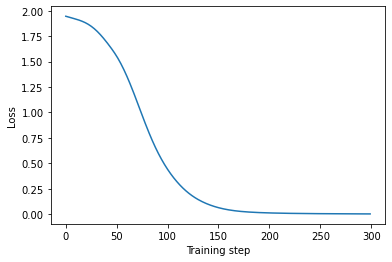

In [ ]:
model = MLPBaseline().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(features, labels, idx_train, model, optimizer, 300)
evaluate(features, labels, idx_val, model)

## == Task 2 ==

[**Question 1**] Implement a Graph Convolutional Network (https://arxiv.org/abs/1609.02907) and train it on the Cora dataset. The network should make a prediction for each of the 2708 nodes, but only be trained and evaluated on the nodes specified by `idx_train` and `idx_val`. Plot its learning curve and report its validation accuracy. Note that you can run the entire graph through the network in a single training step (unless you run out of memory). My MLP baseline above only uses the nodes that have training and validation labels. That is because it does not look at the neighbors (and their neighbors, ...) of labeled nodes. You will have to use all nodes.

[**Question 2**] Is the MLP baseline equivariant to the permutation of nodes (and the corresponding permutation of the adjacency matrix)? What about the Graph Convolutional Network?

[**Question 3**] Plot the number of training steps (you can choose a few discrete values) vs validation accuracy. Is the MLP baseline or the Graph Convolutional Network more prone to overfitting? Why?